# Walsh Floquet Counterdiabatic Driving
Since the start of my PhD, I have been saying this should be tested, so I might as well go and test it. I want to see if I can find a variational solution to the counterdiabatic drive for the following system:
$$\hat{H}(t) = B_z \sigma^z + B_x \text{Sq}(t) \sigma^x,$$
where we drive the system with a square wave that is a single mode in the Walsh basis. We can imagine that we allow $B_x$ to also be time-dependent (henceforth referred to as $\lambda(t)$) and we want to remain in a given Floquet state via counterdiabatic driving. 

The counterdiabatic form of the Hamiltonian is given by
$$\hat{H}_{CD, \lambda(t)} = \hat{H}_{\lambda(t)}(t) + \dot{\lambda} \mathcal{A}_{\lambda(t)}(t).$$

The FAGP can be approximated using the variational principle
$$\mathcal{A}_\lambda \approx \chi_\lambda \text{ where } \mathcal{S}[\chi_\lambda] = \int_0^T \text{Tr}[\mathcal{G}^2(\chi_\lambda(t))] \text{d}t,$$
and we define $\mathcal{G}(\chi_\lambda) = i[H_\lambda(t), \chi_\lambda(t)]+ \partial_t \chi_\lambda-\partial_\lambda H_\lambda$.

While generically it is very complicated to solve for this, we are restricted to the Hilbert space of a single spin and can reduce $\chi_\lambda$ to have four components corresponding to the Pauli matrices. This gives
$$\chi_\lambda = \mathbf{a}(t) \cdot \sigma.$$

## General Functions
For later use, it is in our interest to define several useful pieces. For example, the Pauli matrices among others. We will just define the Walsh derivative locally here for now. For this first pass, we define the functions as three index tensors $f_{ijt}$ where $ij$ describe the physical Hilbert space and t describes the time evolution parameter.

In [3]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
import timeit

#-------------------
# Operation functions
#-------------------

#These functions allow us to perform the general necessary operations between our triple index tensor objects A_{ij,t}.


def commutator(A,B):
    #Finds the commutator for A_{ij, t} and B_{ij, t} for all t.
    #Returns a tensor $C_{ij, t}$ which is the commutator of the matrices at each time
    
    return np.einsum('ijt,jkt->ikt', A, B)-np.einsum('ijt,jkt->ikt', B, A) 

def D(Op,N): 
    #take some operator Op_{ij,t} and find the discretised derivative with respect to time
    #Returns DOp_{ij,t} for a general operator
    
    Walshd=WalshD(N)
    drealspace=-1/N*sp.hadamard(N)@Walshd@sp.hadamard(N) #Negative sign since WalshD is actually the negative derivative right now.
    return np.einsum('ab,jkb->jka', drealspace, Op)  #np.tensordot(Op, drealspace, axes=([2], [1]))



#----------------
# Functions to define the tensor objects
#----------------

#Need to work with time dependent 2x2 matrices, use tensors H_{ij,t} to capture these 
#The last index is the discretised time.


#Pauli matrices
#--------------

s0 = np.eye(2) #identity
s1 = np.array([[0,1],[1,0]]) #sigma_x
s2 = np.array([[0,-1j],[1j,0]]) #sigma_y
s3 = np.array([[1,0],[0,-1]]) #sigma_z
paulis=[s1,s2,s3] #Vector of the Pauli matrices excluding the identity.


def WalshD(N):
    #Input is N=2**n where n is a positive integer. Defines number of modes/discretisation steps
    #Output is (negative) the Walsh derivative truncated to that number of modes
    
    Walsh=sp.hadamard(N) #Generate all the Walsh functions from the Hadamard array.
    translatedWalsh=np.roll(Walsh,1,axis=1) #Shift the whole thing over by 1 by simply pushing all the columns periodically 1.
    Translation=1/N*np.matmul(translatedWalsh,np.transpose(Walsh)) #Invert Ax=x' to A=x' x^T to find the translation operator.

    return N/(2*np.pi)*sp.logm(Translation) #Rewrite it as generator of translations where T=exp(2 pi G/N).


def genOs(N):
    #Input is N=2**n where n is a positive integer. Defines number of modes/discretisation steps
    #Output is a list of 3*N operators, O_{ij,t}. 0, 3, 6, ... are s1*W0, s1*W1, s1*W2, ... respectively. 
    
    Os=[]
    Walsh=1/np.sqrt(N)*sp.hadamard(N) #Normalise the Hadamard
    for i in range(N):
        Wi=Walsh[:,i]
        for s in paulis:
            O=np.stack([s*w for w in Wi], axis=2) 
            Os.append(O)
    return Os

def genDOs(N):
    #Input is N=2**n where n is a positive integer. Defines number of modes/discretisation steps
    #Output is a list of 3*N operators, DO_{ij,t}, where we have differentiated w.r.t time.
    
    DOs=[]

    #Find the derivatives of the Walsh functions in real time
    DWalsh=1/np.sqrt(N)*WalshD(N)@sp.hadamard(N) #Normalise the Hadamard
    for i in range(N):
        DWi=DWalsh[i,:] #Rows are the time-dependence of the differentiated Walsh functions
        for s in paulis:
            DO=np.stack([s*w for w in DWi], axis=2)
            DOs.append(DO)
    return DOs



#-----------------
# Functions for probing output data
#-----------------

#After calculating the AGP, we can use these functions to check that it makes sense. 


#Takes a 2 x 2 hermitian matrix and decomposes it into its constituent paulis
def PauliDecompose(H):
    return 1/2*np.trace(H@s1), 1/2*np.trace(H@s2), 1/2*np.trace(H@s3)

#Time dep pauli decompose
def Paulit(Ht):
    Nt=np.shape(Ht)[-1]
    fs=np.empty((3,Nt), dtype='complex')
    for i in range(Nt):
        f1,f2,f3=PauliDecompose(Ht[:,:,i])
        fvec=[f1,f2,f3]
        for p in range(3): #Iterate over kind of pauli. Identity doesn't affect AGP definition, so don't include.
            fs[p,i]=fvec[p]
    return fs

#Testing if the calculated AGP matches what it should be
def AGPtest(Agp, Ht, dlHt, N):
    #Takes AGP_{ij,t}, H_{ij,t}, dH/dl_{ij,t}, N (power of two)
    #Returns Fitness_{ij,t} which should be zero everywhere if the AGP solution is exact.
    
    Gt=1.j*commutator(Ht,Agp)+D(Agp,N)-dlHt
    return 1.j*commutator(Ht,Gt)+D(Gt,N)

# Case 1: Amplitude Ramp
As the simplest first case we study
$$H(t)= B_z \sigma^z + (g+ \lambda \cdot \text{Sq}(t)) \sigma^x,$$
which has the nice interpretation of an amplitude ramp.

We store this information by using three indices. The Hamiltonian is H(t) is written as H[i,j,t] where the third index gives time. To take the trace over the physical Hilbert space part, it is just ```numpy.trace(H, axis1=0, axis2=1).``` All the operators are also written this way.

What we ultimately want to calculate is
$$
\begin{align}
M_{jk}(\lambda)&= \int \text{d}\phi\, \mathrm{Tr} \left[ g_{j,\lambda}(\phi)g_{k,\lambda}(\phi) \right] \\
b_{j}(\lambda)&= \int \text{d}\phi \mathrm{Tr} \left[ g_{j,\lambda}(\phi) \partial_{\lambda} H_{\lambda}(\phi) \right] \\
g_{j,\lambda}(\phi)&= i[H_{\lambda}(\phi), O_{j}(\phi)] +\omega \partial_{\phi}(O_{j}(\phi))
\end{align}
$$

We store the $O_j$ as "Ops" where the first three elements are time independent $\sigma_x, \sigma_y, \sigma_z$ then the next three are $\sigma_x W_1(t), \sigma_y W_1(t), \sigma_z W_1(t)$ where the label is the natural ordering for the Walsh and so varies with $N$. Note, in the paper there is no $\omega$ dependence to be found. However, there should be since $\partial_t=\omega \partial_\phi$. 

We can then find $\mathbf{x}=\mathbf{M}^{-1} \mathbf{b}$ which defines our approximate AGP as
$$\chi=\sum x_n \hat{O}_n$$

In [16]:
def AGP_vary_A(lam, Ops, DOps, sz, sx, Sqtsx, N):
    """
    Variational AGP construction for a given lambda.

    Parameters
    ----------
    lam : float
        Current value of lambda.
    Ops : np.ndarray
        Operator basis, shape (NOs, 2, 2, N).
        Index order: (basis_index, a, b, t).
    DOps : np.ndarray
        Derivative w.r.t. phi of each operator, same shape as Ops.
    sz, sx, Sqtsx : np.ndarray
        Time-dependent operators (2,2,N) needed to build H(t).
    N : int
        Number of discrete time points.

    Returns
    -------
    AGPapprox : np.ndarray
        Approximate AGP tensor, shape (2, 2, N).
    """
    NOs = len(Ops) #Since it is a list of operators

    #Driving frequency
    omega=100
    
    # Hamiltonian and its lambda derivative
    Ht   = 1 * sz + 0.5 * sx + lam * Sqtsx  # Bz=1, g=0.5
    dlHt = Sqtsx

    # Allocate
    gmatrices = np.empty((NOs, 2, 2, N), dtype=complex)
    bvector   = np.empty((NOs,), dtype=complex)
    Mmatrix   = np.empty((NOs, NOs), dtype=complex)

    # Build g matrices and b vector
    for j in range(NOs):
        gmatrix = 1j * commutator(Ht, Ops[j]) + omega*DOps[j]
        gmatrices[j] = gmatrix
        # b_j = Tr[g_j dlH], integrated over time
        bmatrix = np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrix, dlHt),
                                  axis1=0, axis2=1))
        bvector[j] = bmatrix

    # Build M matrix
    for j1 in range(NOs):
        for j2 in range(j1+1):
            val = np.sum(np.trace(np.einsum('ijt,jkt->ikt',
                                            gmatrices[j1], gmatrices[j2]),
                                  axis1=0, axis2=1))
            Mmatrix[j1, j2] = val
            Mmatrix[j2, j1] = val  # Hermitian

    # Solve M X = b
    Xvector = np.linalg.solve(Mmatrix, bvector)

    # Construct approximate AGP
    AGPapprox = np.einsum('j,jabt->abt', Xvector, Ops)
    constraint = AGPtest(AGPapprox, Ht, dlHt, int(NOs/3)) #Find the number of modes from number of operators.
    print("Remainder if we have AGP=0:")
    print(np.average(np.abs(AGPtest(np.zeros((2,2,N)),Ht, dlHt, int(NOs/3))))) # Prints the error if we do nothing at all.
    return AGPapprox, constraint, Mmatrix

Remainder if we have AGP=0:
0.35355339059327373
[1.62200889e+00 4.74291421e+00 6.36550823e+00 1.96782764e+04
 1.97790115e+04 2.01861828e+04 2.04105155e+04 2.06964312e+04
 2.08512284e+04 7.99959067e+04]


/Users/jamwalk/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jamwalk/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


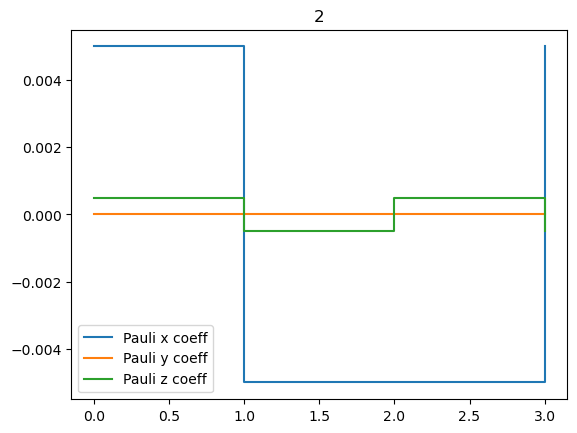

Remainder if we have AGP=0:
0.2815291870148745
[1.69279796e-01 1.29686501e+00 1.46614651e+00 1.96910658e+04
 1.97024330e+04 2.00042252e+04 2.00264920e+04 2.03229980e+04
 2.03347093e+04 7.93794136e+04]


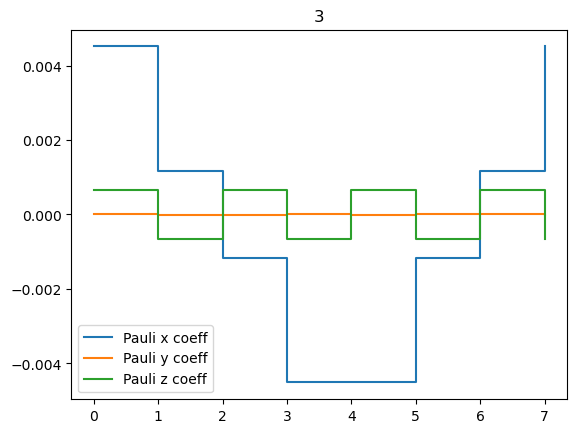

Remainder if we have AGP=0:
0.24125872569227158
[9.84984434e-03 6.26474548e-01 6.36324402e-01 1.97776594e+04
 1.97789479e+04 2.00001953e+04 2.00027524e+04 2.02245100e+04
 2.02258032e+04 7.95542808e+04]


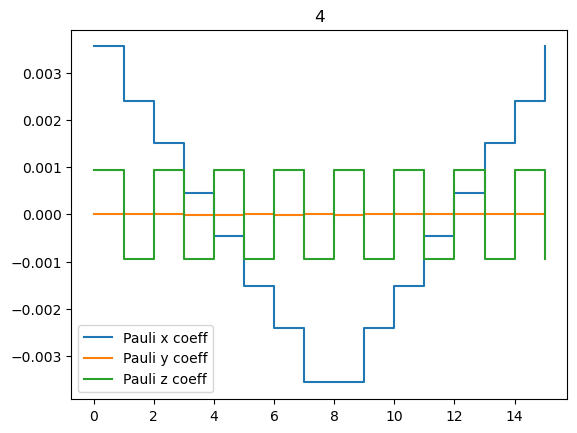

Remainder if we have AGP=0:
0.20567953575595868
[5.65849783e-04 3.12384026e-01 3.12949881e-01 1.98423107e+04
 1.98424679e+04 2.00000108e+04 2.00003245e+04 2.01584082e+04
 2.01585654e+04 7.96842448e+04]


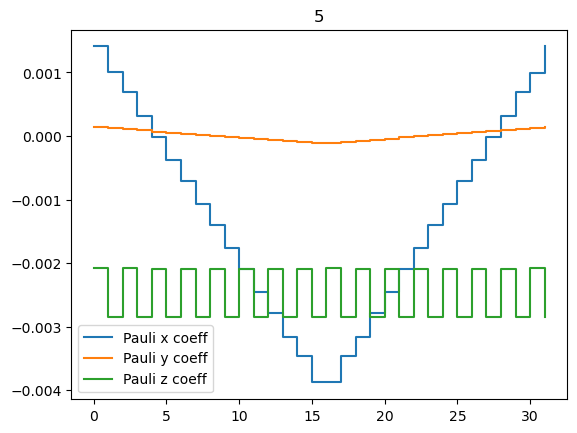

Remainder if we have AGP=0:
0.1717266681246633
[3.32525449e-05 1.56194015e-01 1.56227266e-01 1.98883812e+04
 1.98884007e+04 2.00000006e+04 2.00000397e+04 2.01119419e+04
 2.01119615e+04 7.97765972e+04]


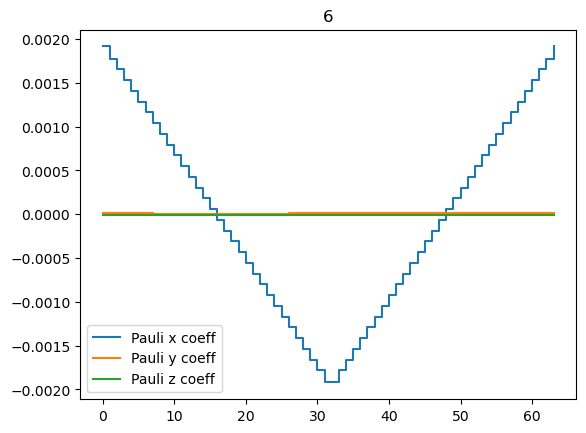

Remainder if we have AGP=0:
0.14048626163708045
[1.99346874e-06 7.81094324e-02 7.81114355e-02 1.99210299e+04
 1.99210324e+04 2.00000000e+04 2.00000049e+04 2.00791276e+04
 2.00791300e+04 7.98419806e+04]


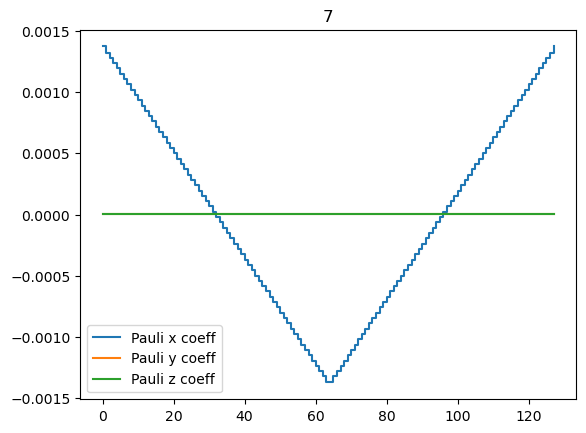

Remainder if we have AGP=0:
0.1129726530334362
[8.60259708e-08 3.90585055e-02 3.90587463e-02 1.99441403e+04
 1.99441406e+04 2.00000000e+04 2.00000006e+04 2.00559380e+04
 2.00559383e+04 7.98882414e+04]


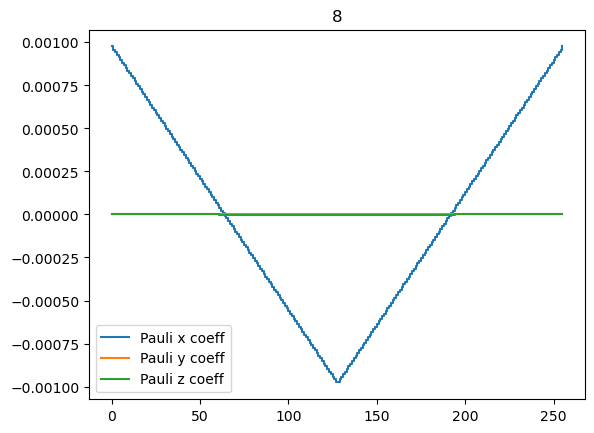

Remainder if we have AGP=0:
0.08957955657653771
[7.32783851e-07 1.95304286e-02 1.95305134e-02 1.99604921e+04
 1.99604921e+04 2.00000000e+04 2.00000001e+04 2.00395470e+04
 2.00395470e+04 7.99209646e+04]


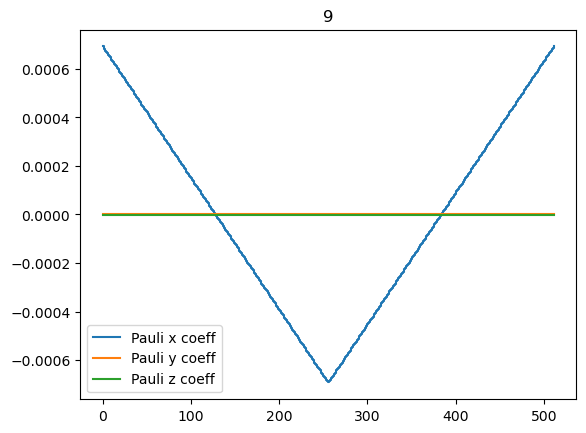

In [17]:
#lambdas=np.arange(0,10,1)

constraints=[]

nvals=np.arange(2,10,1) #np.arange(2,10,1) #11

for n in nvals:
    N=2**n
    #Generate operator set
    Ops=genOs(N)
    DOps=genDOs(N)
    
    sz=Ops[2]
    sx=Ops[0]
    Sqtsx=Ops[int(N/2)*3] #sx is multiples of 3, square wave is the N/2th mode.
    
    #Calculate for a specific lambda and plot
    AGP_approx,constraint, Mmat=AGP_vary_A(10, Ops, DOps, sz, sx, Sqtsx, N) #0.1 #0.3
    print(np.sort(np.abs(np.linalg.eigh(Mmat)[0]))[:10])
    #plt.plot(np.abs(AGP_approx[1,1,:]))
    
    #plt.show()
    constraints.append(constraint)
    #Decompose into different paulis
    funcs=Paulit(AGP_approx)
    plt.plot(funcs[0,:], label="Pauli x coeff", drawstyle='steps-post')
    plt.plot(funcs[1,:], label="Pauli y coeff", drawstyle='steps-post')
    plt.plot(funcs[2,:], label="Pauli z coeff", drawstyle='steps-post')
    plt.title(n)
    plt.legend()
    plt.show()

# for lam in lambdas:
#     AGP_vary_A(lam, Ops, DOps, sz, sx, Sqtsx, N)

In [15]:
np.sort(np.abs(np.linalg.eigh(Mmat)[0]))[:10]

array([8.60259708e-08, 3.90585055e-02, 3.90587463e-02, 1.99441403e+04,
       1.99441406e+04, 2.00000000e+04, 2.00000006e+04, 2.00559380e+04,
       2.00559383e+04, 7.98882414e+04])

In [10]:
#Evaluate the fitness of the approximate AGP from truncation
fitness=[np.average(np.abs(constraint)) for constraint in constraints]
fitness

[5.5181866037589105,
 32.74038807228267,
 229.41353566792765,
 469.5971373871717,
 2.4306220994099887,
 0.14309445039867386,
 0.11188538757952227,
 0.08869787832245962]

## Calculating the AGP without truncation
For a simple two-level system, we can find the Floquet AGP without truncating at all. The formula we use is
$$\mathcal{A}_\lambda(t)= i \partial_\lambda ( P_\lambda(t) W_\lambda) W_\lambda^\dagger P_\lambda^\dagger(t).$$

Below we calculate the following:
1. Find $W_\lambda$ which is the diagonalisation unitary for $H_{F,\lambda}$ i.e $\Lambda_{F,\lambda}=W^\dagger_\lambda H_{F,\lambda} W_\lambda$
2. Find the micromotion operator $P_\lambda(t)=e^{+i H_{F,\lambda} t} U_\lambda(t)$
3. Calculate $\mathcal{A}_\lambda(t)$ by combining them together. For the derivative, we will approximate such that$$\mathcal{A}_\lambda(t) \approx i \frac{(P_{\lambda+\delta \lambda}(t) W_{\lambda+\delta \lambda} -P_{\lambda}(t) W_{\lambda})}{\delta \lambda} W_\lambda^\dagger P_\lambda^\dagger(t) \approx i \frac{(P_{\lambda+\delta \lambda}(t) W_{\lambda+\delta \lambda}W_\lambda^\dagger P_\lambda^\dagger(t) - \mathbb{1})}{\delta \lambda} $$


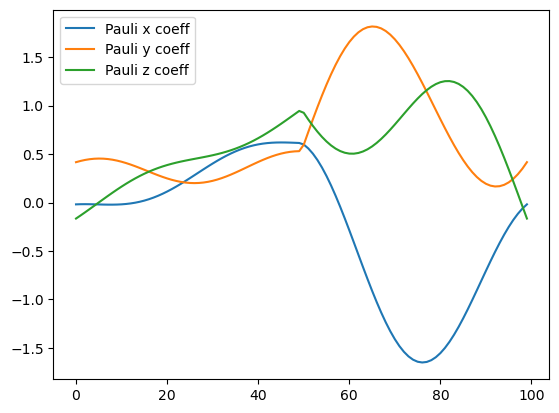

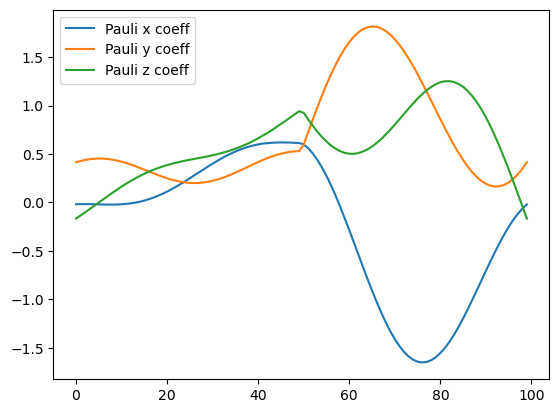

In [ ]:
#Calculate the FAGP numerically without truncation since it is a simple two-level system

#----------------
#Find the Floquet Hamiltonian and Wlam
#----------------

def UT(Bz,g,lam, T):
    return sp.expm(-1.j*(Bz*s3+(g-lam)*s1)*T/2)@sp.expm(-1.j*(Bz*s3+(g+lam)*s1)*T/2)
    
def HFlam(Bz,g,lam, T):
    #Takes float parameters Bz, g, A=lam, omega
    #Returns 2 x 2 Floquet Hamiltonian

    return 1.j/T*sp.logm(UT(Bz,g,lam,T)) #Floquet Hamiltonian is log of Floquet unitary.

def Wlam(Bz, g, lam, T):
    #Takes float parameters Bz, g, A=lam, omega
    #Returns 2 x 2 matrix Wlam_{i,j}


    eigvals, eigvecs = np.linalg.eigh(HFlam(Bz,g,lam,T)) #Diagonalise HFlam

    return eigvecs


#---------------
# Find the micromotion operator
#---------------

def Ulam(t, Bz, g, lam, T):
    NC = t//T #Find the number of complete cycles
    tr = t%T #Find the time remaining after complete cycles.

    U_strob=np.linalg.matrix_power(UT(Bz,g,lam,T), int(NC)) 
    
    if tr < T/2:
        return sp.expm(-1.j*(Bz*s3+(g+lam)*s1)*tr)@U_strob
    else:
        return sp.expm(-1.j*(Bz*s3+(g-lam)*s1)*(tr-T/2))@sp.expm(-1.j*(Bz*s3+(g+lam)*s1)*T/2)@U_strob

def Plam(t, Bz, g, lam, T):
    return Ulam(t,Bz,g,lam,T)@sp.expm(1.j*HFlam(Bz,g,lam,T)*t) #Micromotion operator


#---------------
# Calculate AGP
#---------------

#To do the lambda derivative, we are going to take a small difference in lambda between them.
#Define WW=W_{\lambda+deltalambda} W_lambda^dagger to save the effort of re-calculating this.
def AGPlam_num(t, Bz, g, lam, T, dl, WW):
    P2W2W1P1= Plam(t,Bz,g,lam+dl,T)@WW@(Plam(t,Bz,g,lam,T).conj().T)
    return 1.j*(P2W2W1P1-np.eye(2))/dl

def AGPlamPlot(Bz, g, lam, T,dl):
    #Define the desired parameters
    #dl=4*10**(-6) #Step-size for the derivative
    WW=Wlam(Bz, g, lam+dl, T)@(Wlam(Bz, g, lam, T).conj().T) #Find the W product

    #Define the t range for plotting
    Nt=100
    tvals=np.linspace(0,T,Nt)
    funcs=np.empty((3,Nt), dtype="complex")#Storing the time-dependence of the different parts
    for i,t in enumerate(tvals):
        AGP_num=AGPlam_num(t,Bz,g,lam, T,dl,WW)
        funcs[0,i], funcs[1,i], funcs[2,i]=PauliDecompose(AGP_num)
    
    plt.plot(funcs[0,:], label="Pauli x coeff")
    plt.plot(funcs[1,:], label="Pauli y coeff")
    plt.plot(funcs[2,:], label="Pauli z coeff")
    plt.legend()
    plt.show()

AGPlamPlot(1,0.5,0.3, 2*np.pi, 4*10**(-6))
AGPlamPlot(1,0.5,0.3, 2*np.pi, 4*10**(-13))

In [383]:
#--------------------------
# Test if the AGP is correct
#--------------------------

def commt(A,B):
    return A@B-B@A
    
def numAGPtest(Bz, g, lam, T, Nt):
    #Define the desired parameters
    dl=0.01 #Step-size for the derivative
    WW=Wlam(Bz, g, lam+dl, T)@(Wlam(Bz, g, lam, T).conj().T) #Find the W product
    
    #Define the t range for plotting
    Nt=100
    tvals=np.linspace(0,T,Nt)
    dt=tvals[1]-tvals[0]
    errors=[]

    #Storing the precomputed values
    A_list   = [AGPlam_num(t,Bz,g,lam, T,dl,WW) for t in tvals]
    H_list   = [Bz*s3 + (g + lam)*s1 if t < T/2 else Bz*s3 + (g - lam)*s1 for t in tvals]
    dHl_list = [s1 if t < T/2 else -s1 for t in tvals]

    G_list = [1.j*commt(H_list[i],A_list[i]) + (A_list[i]-A_list[i-1])/dt - dHl_list[i] for i in range(1,Nt)]
    
    for (i,Gt) in enumerate(G_list):
        error=np.abs(1.j*commt(H_list[i],Gt)+(G_list[i+1]-G_list[i])/dt)
        errors.append(error)
        print(error)
    return errors

numAGPtest(1,0.5,0.3, 0.1, 10)

[[0.23515674 4.00249897]
 [4.00232945 0.23515674]]
[[0.2480604  4.00186851]
 [4.00169091 0.2480604 ]]
[[0.26096215 4.00125175]
 [4.00106607 0.26096215]]
[[0.27386174 4.00064874]
 [4.00045497 0.27386175]]
[[0.28675899 4.00005951]
 [3.99985766 0.28675899]]
[[0.29965369 3.9994841 ]
 [3.99927417 0.29965369]]
[[0.31254568 3.99892257]
 [3.99870456 0.31254568]]
[[0.32543482 3.99837496]
 [3.99814887 0.32543482]]
[[0.33832096 3.9978413 ]
 [3.99760714 0.33832095]]
[[0.35120396 3.99732166]
 [3.99707942 0.35120396]]
[[0.36408371 3.99681607]
 [3.99656575 0.36408371]]
[[0.37696008 3.99632458]
 [3.99606619 0.37696008]]
[[0.38983297 3.99584723]
 [3.99558077 0.38983297]]
[[0.40270226 3.99538409]
 [3.99510955 0.40270226]]
[[0.41556786 3.99493519]
 [3.99465258 0.41556786]]
[[0.42842966 3.99450058]
 [3.99420991 0.42842966]]
[[0.44128755 3.99408032]
 [3.99378158 0.44128755]]
[[0.45414146 3.99367445]
 [3.99336765 0.45414146]]
[[0.46699127 3.99328303]
 [3.99296817 0.46699127]]
[[0.47983691 3.99290611]
 [3.99

IndexError: list index out of range

In [432]:
import numpy as np

# assumes you already have: s1, s3, Wlam, AGPlam_num, and commt(A,B)=A@B-B@A

def central_derivative_periodic(M_list, dt):
    """Central difference with periodic wrap; returns list same length as input."""
    N = len(M_list)
    dM = []
    for i in range(N):
        ip = (i + 1) % N
        im = (i - 1) % N
        dM.append((M_list[ip] - M_list[im]) / (2.0 * dt))
    return dM

def numAGPtest_S6(Bz, g, lam, T, Nt, dl=0.01, use_halfstep_sq=True):
    """
    Check S6:  i[H, G] + dG/dt = 0,  with G = i[H, A] + dA/dt - ∂_λ H.
    Uses your AGPlam_num(t,Bz,g,lam,T,dl,WW) and WW built from Wlam.
    Returns: t-grid, ||G(t)||_F, ||i[H,G]+dG/dt||_F, and their maxima.
    """
    # time grid (periodic)
    tvals = np.linspace(0.0, T, Nt, endpoint=False)
    dt = tvals[1] - tvals[0]

    # Precompute the WW product exactly as in your code
    WW = Wlam(Bz, g, lam + dl, T) @ (Wlam(Bz, g, lam, T).conj().T)

    # Your AGP values A(t)
    A_list = [AGPlam_num(t, Bz, g, lam, T, dl, WW) for t in tvals]

    # H(t) and ∂_λ H(t) for the odd square wave (single sign flip per half-period)
    if use_halfstep_sq:
        H_list   = [Bz*s3 + (g + lam)*s1 if t < T/2 else Bz*s3 + (g - lam)*s1 for t in tvals]
        dHl_list = [ s1                      if t < T/2 else -s1                      for t in tvals]
    else:
        omega = 2.0*np.pi / T
        Sq = np.sign(np.sin(omega * tvals)); Sq[Sq == 0] = 1.0
        H_list   = [(Bz*s3 + (g + lam*Sq[k]) * s1) for k in range(Nt)]
        dHl_list = [(Sq[k] * s1) for k in range(Nt)]

    # dA/dt via central difference with periodic wrap
    dA_dt_list = central_derivative_periodic(A_list, dt)

    # G(t) = i[H,A] + dA/dt - ∂_λ H
    G_list = [1j * commt(H_list[i], A_list[i]) + dA_dt_list[i] - dHl_list[i]
              for i in range(Nt)]

    # dG/dt and the S6 residual R(t) = i[H,G] + dG/dt
    dG_dt_list = central_derivative_periodic(G_list, dt)df
    R_list = [1j * commt(H_list[i], G_list[i]) + dG_dt_list[i] for i in range(Nt)]

    # Scalar diagnostics (Frobenius norms)
    G_norms = np.array([np.linalg.norm(G, 'fro') for G in G_list])
    R_norms = np.array([np.linalg.norm(R, 'fro') for R in R_list])

    return tvals, G_norms, R_norms, G_norms.max(), R_norms.max()
ts, Gs, Rs, maxG, maxR=numAGPtest_S6(1,0.5, 0.3, 2*np.pi, 1000)
Rs

array([3.90811697e+02, 1.54555377e+02, 2.45826922e-01, 2.45925802e-01,
       2.46049646e-01, 2.46198448e-01, 2.46372194e-01, 2.46570858e-01,
       2.46794404e-01, 2.47042788e-01, 2.47315955e-01, 2.47613841e-01,
       2.47936370e-01, 2.48283460e-01, 2.48655017e-01, 2.49050941e-01,
       2.49471119e-01, 2.49915433e-01, 2.50383754e-01, 2.50875946e-01,
       2.51391864e-01, 2.51931357e-01, 2.52494263e-01, 2.53080416e-01,
       2.53689641e-01, 2.54321757e-01, 2.54976575e-01, 2.55653902e-01,
       2.56353537e-01, 2.57075274e-01, 2.57818900e-01, 2.58584201e-01,
       2.59370952e-01, 2.60178929e-01, 2.61007899e-01, 2.61857629e-01,
       2.62727879e-01, 2.63618407e-01, 2.64528967e-01, 2.65459311e-01,
       2.66409186e-01, 2.67378340e-01, 2.68366516e-01, 2.69373456e-01,
       2.70398900e-01, 2.71442587e-01, 2.72504254e-01, 2.73583637e-01,
       2.74680473e-01, 2.75794495e-01, 2.76925439e-01, 2.78073039e-01,
       2.79237029e-01, 2.80417144e-01, 2.81613118e-01, 2.82824688e-01,
      

In [338]:
HF=HFlam(2,0.3,1,10)
array=np.zeros(3)
print(PauliDecompose(HF))
array[0],array[1],array[2]=PauliDecompose(HF)
print(array)
eigvals, eigvecs = np.linalg.eigh(HF)
print(eigvals)
eigvecs.conj().T@HF@eigvecs

((0.11102125802259057-9.71445146547012e-17j), (0.13015055235081485+1.3877787807814457e-17j), (-0.1502776557269623-2.516506045725676e-17j))
[ 0.11102126  0.13015055 -0.15027766]
[-0.22770213  0.22770213]


/var/folders/h3/s252cnjs1fg5q_2y8x3vh8mr0000gp/T/ipykernel_90737/3291558088.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  array[0],array[1],array[2]=PauliDecompose(HF)


array([[-2.27702130e-01-3.61393895e-17j,  1.36055374e-16-9.34257287e-17j],
       [-1.25719366e-17-1.11695536e-17j,  2.27702130e-01-7.95519617e-17j]])

## Handling in the Fourier basis
it appears that in the Fourier basis, the calculation can't be nearly as smooth since we have to repeatedly truncate at several different steps. However, when we study the final form of the AGP, it appears that it would be well-suited to the Fourier basis. Thus, it is worth investigating exactly how this pans out in the other basis


Residual ||M x - b|| = 8.664696440443991e-15

Grouped coefficients (by Pauli, then Fourier mode):

[sx]
  const: -1.833232584239714e-15
  sin : {1: -2.1105025494430695e-15, 2: -0.4963829371561035, 3: 4.344036195954887e-16, 4: 0.019521438713472526, 5: 1.9762326198923925e-17, 6: 0.004632092092683227, 7: 1.4555341555605417e-17}
  cos : {1: 0.08216278071883519, 2: -2.1358694068798593e-15, 3: -0.25348427525965905, 4: 3.014545988595012e-17, 5: -0.06050219628493682, 6: 2.2648571691004817e-18, 7: -0.02830042807121692}

[sy]
  const: -0.04491433952303086
  sin : {1: 0.6324987456758441, 2: -2.3263589150970654e-15, 3: -0.15901461176682255, 4: 2.858466578482219e-17, 5: -0.022585942086201353, 6: -7.288215159570579e-18, 7: -0.007629054496699898}
  cos : {1: 1.098209579544047e-15, 2: 0.46653451359013415, 3: -5.544955781455866e-16, 4: -0.038155810819117175, 5: -7.108644438738182e-17, 6: -0.013520153058532393, 7: -5.214655663656006e-17}

[sz]
  const: -3.6215210206760904e-15
  sin : {1: -1.506462024751

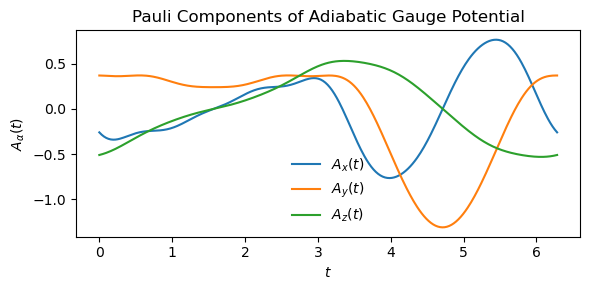

In [422]:
import numpy as np

# ---------- Pauli matrices ----------
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)
I2 = np.eye(2, dtype=complex)

def comm(A, B):
    return A @ B - B @ A

# ---------- Square wave and truncated Fourier ----------
def square_wave_phi(phi):
    """Odd square wave sgn(sin(phi)), values in {-1, +1}."""
    s = np.sin(phi)
    return np.where(s >= 0.0, 1.0, -1.0)

def square_wave_fourier_truncated(phi, Nmax):
    """Truncated Fourier series of odd square wave up to odd n<=Nmax."""
    out = np.zeros_like(phi, dtype=float)
    for k in range(1, Nmax + 1, 2):  # odd only
        out += (4.0 / np.pi) * np.sin(k * phi) / k
    return out

# ---------- Hamiltonian H_4(phi) and dH/dlambda ----------
def H4(phi, Bz, g, lam, use_truncated_sq=False, Nmax_sq=9):
    """
    H_4(phi) = Bz * sz + (g + lam * Sq(phi)) * sx
    """
    Sq = square_wave_fourier_truncated(phi, Nmax_sq) if use_truncated_sq else square_wave_phi(phi)
    Hx = (g + lam * Sq)[:, None, None] * sx
    Hz = (Bz * np.ones_like(Sq))[:, None, None] * sz
    return Hx + Hz

def dH4_dlambda(phi, use_truncated_sq=False, Nmax_sq=9):
    """∂_λ H_4(phi) = Sq(phi) * sx."""
    Sq = square_wave_fourier_truncated(phi, Nmax_sq) if use_truncated_sq else square_wave_phi(phi)
    return (Sq[:, None, None]) * sx

# ---------- Fourier basis ----------
def basis_funcs(Ncut):
    """
    Return list of (name, f(phi), df(phi)) for modes:
    'const', 'sin1','cos1',...'sinN','cosN'
    """
    modes = []
    modes.append(("const", lambda phi: np.ones_like(phi), lambda phi: np.zeros_like(phi)))
    for n in range(1, Ncut + 1):
        modes.append((f"sin{n}", lambda phi, n=n: np.sin(n * phi),
                               lambda phi, n=n: n * np.cos(n * phi)))
        modes.append((f"cos{n}", lambda phi, n=n: np.cos(n * phi),
                               lambda phi, n=n: -n * np.sin(n * phi)))
    return modes  # length = 1 + 2*Ncut

def pauli_set():
    # Grouping order: σx, then σy, then σz
    return [("sx", sx), ("sy", sy), ("sz", sz)]

def index_map(Ncut):
    """
    Build index mapping (for packing/unpacking x):
    order: all σx modes, then all σy modes, then all σz modes.
    Returns:
      - entries: list of tuples (pname, mname, idx)
      - lookup: dict (pname -> dict(mname -> idx))
      - mode_names: ordered list of mode names per Fourier block
    """
    modes = [m[0] for m in basis_funcs(Ncut)]  # names only
    entries = []
    lookup = {}
    idx = 0
    for pname, _ in pauli_set():
        lookup[pname] = {}
        for mname in modes:
            entries.append((pname, mname, idx))
            lookup[pname][mname] = idx
            idx += 1
    return entries, lookup, modes

# ---------- Build M and b (S64) for the full σx/σy/σz ansatz ----------
def build_linear_system(Bz, g, lam, Ncut, nphi=4096, use_truncated_sq=False, Nmax_sq=9):
    """
    Ansatz O_{(p,m)}(φ) = f_m(φ) * σ^p,   p ∈ {x,y,z}, m over Fourier modes.
    s_{(p,m)}(φ) = i[H_4(φ), O_{(p,m)}(φ)] + ∂_φ O_{(p,m)}(φ).
    M_{(p,m),(q,n)} = ∫ dφ Tr(s_{(p,m)}^† s_{(q,n)}),
    b_{(p,m)}        = ∫ dφ Tr(s_{(p,m)}^† ∂_λ H_4(φ)).
    """
    # φ grid
    phi = np.linspace(0.0, 2.0 * np.pi, nphi, endpoint=False)
    dphi = 2.0 * np.pi / nphi

    # Precompute H4 and dH/dλ
    Hphi = H4(phi, Bz, g, lam, use_truncated_sq=use_truncated_sq, Nmax_sq=Nmax_sq)
    dHlam = dH4_dlambda(phi, use_truncated_sq=use_truncated_sq, Nmax_sq=Nmax_sq)

    # Basis structures
    p_list = pauli_set()            # [("sx",sx), ("sy",sy), ("sz",sz)]
    m_list = basis_funcs(Ncut)      # list of (mname, f, df)
    entries, lookup, mode_names = index_map(Ncut)

    J = len(entries)
    M = np.zeros((J, J), dtype=float)
    b = np.zeros(J, dtype=float)

    # Precompute f_m(φ), df_m(φ) for all modes (vectorized)
    f_vals = {}
    df_vals = {}
    for mname, f, df in m_list:
        f_vals[mname] = f(phi)[:, None, None]   # (nphi,1,1)
        df_vals[mname] = df(phi)[:, None, None]

    # Helper for Tr(A^† B) along φ
    def trAHB(A, B):
        return np.einsum('kij,kij->k', np.conjugate(A), B).real

    # Construct all s_{(p,m)}(φ) once and store
    s_all = [None] * J
    for (pname, mname, idx) in entries:
        # Pick Pauli
        P = dict(sx=sx, sy=sy, sz=sz)[pname]
        # O_{(p,m)} = f_m * P ; dO/dφ = df_m * P
        Oj = f_vals[mname] * P
        dOj = df_vals[mname] * P
        sj = 1j * (Hphi @ Oj - Oj @ Hphi) + dOj
        s_all[idx] = sj

    # Assemble M and b
    for a, (pname_a, mname_a, idx_a) in enumerate(entries):
        sj = s_all[idx_a]
        b_phi = trAHB(sj, dHlam)
        b[idx_a] = np.sum(b_phi) * dphi
        for b_ind in range(a, J):
            sk = s_all[entries[b_ind][2]]
            M_phi = trAHB(sj, sk)
            Mval = np.sum(M_phi) * dphi
            M[idx_a, entries[b_ind][2]] = Mval
            M[entries[b_ind][2], idx_a] = Mval  # symmetry

    return M, b, phi, entries, lookup, mode_names

def solve_fagp(Bz, g, lam, Ncut, nphi=4096, use_truncated_sq=False, Nmax_sq=9):
    """
    Solve Mx=b for the stacked (σx, σy, σz)-grouped Fourier ansatz.
    Returns:
      - coeffs (flat 1D array in grouped order),
      - coeffs_grouped (nested dict by Pauli -> {'const', 'sin', 'cos'}),
      - chi_lambda(phi) evaluator -> (len(phi),2,2),
      - residual norm ||Mx-b||,
      - entries/mode_names for reference.
    """
    M, b, phi_grid, entries, lookup, mode_names = build_linear_system(
        Bz, g, lam, Ncut, nphi=nphi, use_truncated_sq=use_truncated_sq, Nmax_sq=Nmax_sq
    )

    x = np.linalg.solve(M, b)
    resid = np.linalg.norm(M @ x - b)

    # Pack into grouped dict
    def empty_block():
        return {"const": 0.0, "sin": {}, "cos": {}}

    grouped = {"sx": empty_block(), "sy": empty_block(), "sz": empty_block()}
    for pname, mname, idx in entries:
        val = float(x[idx])  # real by construction here
        if mname == "const":
            grouped[pname]["const"] = val
        elif mname.startswith("sin"):
            n = int(mname[3:])
            grouped[pname]["sin"][n] = val
        elif mname.startswith("cos"):
            n = int(mname[3:])
            grouped[pname]["cos"][n] = val

    # Evaluator for χλ(φ)
    def chi_lambda(phi):
        phi = np.atleast_1d(phi)
        Chi = np.zeros((len(phi), 2, 2), dtype=complex)
        # σx block
        block = grouped["sx"]
        Chi += block["const"] * sx
        for n, c in block["sin"].items():
            Chi += c * np.sin(n * phi)[:, None, None] * sx
        for n, c in block["cos"].items():
            Chi += c * np.cos(n * phi)[:, None, None] * sx
        # σy block
        block = grouped["sy"]
        Chi += block["const"] * sy
        for n, c in block["sin"].items():
            Chi += c * np.sin(n * phi)[:, None, None] * sy
        for n, c in block["cos"].items():
            Chi += c * np.cos(n * phi)[:, None, None] * sy
        # σz block
        block = grouped["sz"]
        Chi += block["const"] * sz
        for n, c in block["sin"].items():
            Chi += c * np.sin(n * phi)[:, None, None] * sz
        for n, c in block["cos"].items():
            Chi += c * np.cos(n * phi)[:, None, None] * sz
        return Chi

    return x, grouped, chi_lambda, resid, entries, mode_names

# ---------- Example usage ----------
if __name__ == "__main__":
    Bz, g, lam = 1.0, 0.5, 0.3
    Ncut = 7        # Fourier cutoff for χ (1, sin/cos up to n=Ncut)
    nphi = 4096

    # Choose how to represent the square wave in H:
    # exact sign(sin φ) or its truncated Fourier with hard cutoff
    use_trunc_sq = True
    Nmax_sq = 21

    coeffs, grouped, chi_fun, resid, entries, modes = solve_fagp(
        Bz, g, lam, Ncut, nphi=nphi, use_truncated_sq=use_trunc_sq, Nmax_sq=Nmax_sq
    )

    print("Residual ||M x - b|| =", resid)
    print("\nGrouped coefficients (by Pauli, then Fourier mode):")
    for pname in ["sx", "sy", "sz"]:
        blk = grouped[pname]
        print(f"\n[{pname}]")
        print("  const:", blk["const"])
        print("  sin :", dict(sorted(blk["sin"].items())))
        print("  cos :", dict(sorted(blk["cos"].items())))

    # Quick sanity checks
    phi_samp = np.linspace(0, 2*np.pi, 100, endpoint=False)
    Chi = chi_fun(phi_samp)
    herm_err = np.max(np.linalg.norm(Chi - np.conjugate(np.swapaxes(Chi, -2, -1)), axis=(1,2)))
    print("\nMax Hermiticity error over samples:", herm_err)

# --- Define time / phase grid ---
omega = 1.0        # or whatever driving frequency you want
phi_vals = np.linspace(0, 2*np.pi, 400)
t_vals = phi_vals / omega

# --- Evaluate χλ(φ) on the grid ---
Chi_vals = chi_fun(phi_vals)  # shape (len(phi), 2, 2)

# --- Extract Pauli components A_x(t), A_y(t), A_z(t) ---
def pauli_components(Chi):
    """Return components A_x, A_y, A_z = 0.5 * Tr[Chi σ^α]."""
    Ax = 0.5 * np.trace(Chi @ sx, axis1=-2, axis2=-1).real
    Ay = 0.5 * np.trace(Chi @ sy, axis1=-2, axis2=-1).real
    Az = 0.5 * np.trace(Chi @ sz, axis1=-2, axis2=-1).real
    return Ax, Ay, Az

Ax, Ay, Az = pauli_components(Chi_vals)

# --- Plot time evolution of each component ---
plt.figure(figsize=(6, 3))
plt.plot(t_vals, Ax, label=r'$A_x(t)$')
plt.plot(t_vals, Ay, label=r'$A_y(t)$')
plt.plot(t_vals, Az, label=r'$A_z(t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$A_\alpha(t)$')
plt.title('Pauli Components of Adiabatic Gauge Potential')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Case 2: Ramp static field
As a second case, we study
$$H(t)= \lambda \sigma^z + (g+ A \cdot \text{Sq}(t)) \sigma^x,$$

using the same formalism discussed for case 1. This case is more counterintuitive for zero lambda, so it might make sense to go from some large lambda to some other relatively large lambda.

In [15]:
def AGP_vary_z(lam, Ops, DOps, sz, sx, Sqtsx, N):
    """
    Variational AGP construction for a given lambda.

    Parameters
    ----------
    lam : float
        Current value of lambda.
    Ops : np.ndarray
        Operator basis, shape (NOs, 2, 2, N).
        Index order: (basis_index, a, b, t).
    DOps : np.ndarray
        Derivative w.r.t. phi of each operator, same shape as Ops.
    sz, sx, Sqtsx : np.ndarray
        Time-dependent operators (2,2,N) needed to build H(t).
    N : int
        Number of discrete time points.

    Returns
    -------
    AGPapprox : np.ndarray
        Approximate AGP tensor, shape (2, 2, N).
    """
    NOs = Ops.shape[0]

    # Hamiltonian and its lambda derivative
    Ht   = lam * sz + 1.0 * sx + 3.0 * Sqtsx  # g=1, A=3
    dlHt = sz

    # Allocate
    gmatrices = np.empty((NOs, 2, 2, N), dtype=complex)
    bvector   = np.empty((NOs,), dtype=complex)
    Mmatrix   = np.empty((NOs, NOs), dtype=complex)

    # Build g matrices and b vector
    for j in range(NOs):
        gmatrix = 1j * commutator(Ht, Ops[j]) + DOps[j]
        gmatrices[j] = gmatrix
        # b_j = Tr[g_j dlH], integrated over time
        bmatrix = np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrix, dlHt),
                                  axis1=0, axis2=1))
        bvector[j] = bmatrix

    # Build M matrix
    for j1 in range(NOs):
        for j2 in range(j1+1):
            val = np.sum(np.trace(np.einsum('ijt,jkt->ikt',
                                            gmatrices[j1], gmatrices[j2]),
                                  axis1=0, axis2=1))
            Mmatrix[j1, j2] = val
            Mmatrix[j2, j1] = val  # Hermitian

    # Solve M X = b
    Xvector = np.linalg.solve(Mmatrix, bvector)

    # Construct approximate AGP
    AGPapprox = np.einsum('j,jabt->abt', Xvector, Ops)

    return AGPapprox

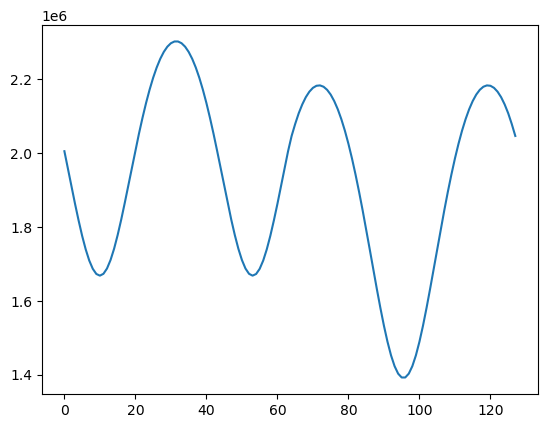

In [13]:
n=7
N=2**n
#Generate operator set
Ops=genOs(N)
DOps=genDOs(N)

sz=Ops[2]
sx=Ops[0]
Sqtsx=Ops[int(N/2)*3] #sx is multiples of 3, square wave is the N/2th mode.
dSqtsx=DOps[int(N/2)*3]

l=1 #1
g=1 #1
A=0.1 #3
#In the Os basis
Ht=l*sz+g*sx+A*Sqtsx
dlHt=sz

NOs=len(Ops)
gmatrices=np.empty((NOs,2,2,N),dtype='complex') #j, a,b, t are the indices.
bvector=np.empty((NOs),dtype='complex') #j, a,b, t are the indices.
Mmatrix=np.empty((NOs,NOs), dtype='complex')

#Now want to find g matrix g[a,b][t] along with the bvector b[j]
for index in range(NOs):
    gmatrix=1.j*commutator(Ht,Ops[index])+DOps[index]
    bmatrix=np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrix, dlHt) ,axis1=0,axis2=1)) #TK can optimise this later in terms of run time.

    #Store the values
    gmatrices[index,:,:,:]=gmatrix
    bvector[index]=bmatrix

#Calculate the M matrices as well. (TK Unchecked)
for index1 in range(NOs):
    for index2 in range(index1+1): #go up to index1 to populate diagonals too.
        Mmatrix[index1,index2]=np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrices[index1], gmatrices[index2]), axis1=0,axis2=1)) #Outer sum is just the integral.
        Mmatrix[index2,index1]=Mmatrix[index1,index2]

#plt.plot(np.abs(bvector)) #bvector only has 2 components which is sensible. Only works for


#Now we can find the X vector that allows us to construct the approximate AGP
Xvector=np.linalg.inv(Mmatrix)@bvector
AGPapprox=np.einsum('j,jabt->abt', Xvector, Ops)
plt.plot(np.abs(AGPapprox[1,0,:]))

# Case 2
As the next case, we study
$$H(t)= B_z \sigma^z + (g+ \lambda \cdot \text{Sq}(t)) \sigma^x,$$

which is nice since it has the interpretation of a ramp in the driving strength. Otherwise, the procedure for calculation is the same as the first case.

In [240]:
def AGP_vary_A(lam, Ops, DOps, sz, sx, Sqtsx, N):
    """
    Variational AGP construction for a given lambda.

    Parameters
    ----------
    lam : float
        Current value of lambda.
    Ops : np.ndarray
        Operator basis, shape (NOs, 2, 2, N).
        Index order: (basis_index, a, b, t).
    DOps : np.ndarray
        Derivative w.r.t. phi of each operator, same shape as Ops.
    sz, sx, Sqtsx : np.ndarray
        Time-dependent operators (2,2,N) needed to build H(t).
    N : int
        Number of discrete time points.

    Returns
    -------
    AGPapprox : np.ndarray
        Approximate AGP tensor, shape (2, 2, N).
    """
    NOs = len(Ops) #Since it is a list of operators

    # Hamiltonian and its lambda derivative
    Ht   = 1 * sz + 0.5 * sx + lam * Sqtsx  # Bz=1, g=0.5
    dlHt = Sqtsx

    # Allocate
    gmatrices = np.empty((NOs, 2, 2, N), dtype=complex)
    bvector   = np.empty((NOs,), dtype=complex)
    Mmatrix   = np.empty((NOs, NOs), dtype=complex)

    # Build g matrices and b vector
    for j in range(NOs):
        gmatrix = 1j * commutator(Ht, Ops[j]) + DOps[j]
        gmatrices[j] = gmatrix
        # b_j = Tr[g_j dlH], integrated over time
        bmatrix = np.sum(np.trace(np.einsum('ijt,jkt->ikt', gmatrix, dlHt),
                                  axis1=0, axis2=1))
        bvector[j] = bmatrix

    # Build M matrix
    for j1 in range(NOs):
        for j2 in range(j1+1):
            val = np.sum(np.trace(np.einsum('ijt,jkt->ikt',
                                            gmatrices[j1], gmatrices[j2]),
                                  axis1=0, axis2=1))
            Mmatrix[j1, j2] = val
            Mmatrix[j2, j1] = val  # Hermitian

    # Solve M X = b
    Xvector = np.linalg.solve(Mmatrix, bvector)

    # Construct approximate AGP
    AGPapprox = np.einsum('j,jabt->abt', Xvector, Ops)
    constraint = AGPtest(AGPapprox, Ht, dlHt, int(NOs/3)) #Find the number of modes from number of operators.
    return AGPapprox, constraint

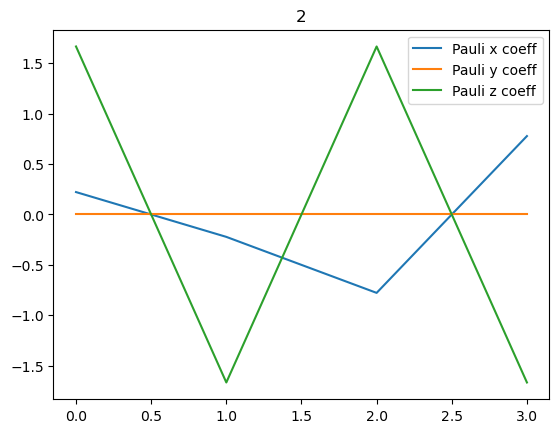

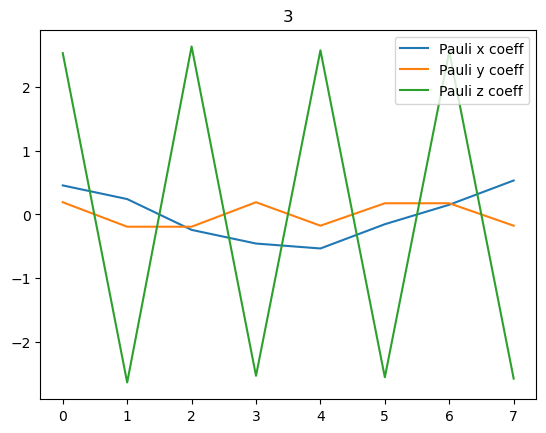

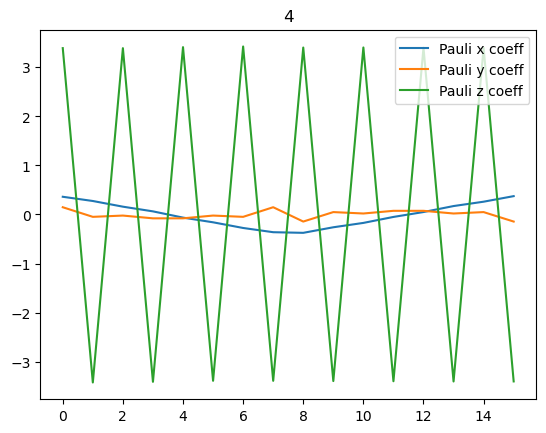

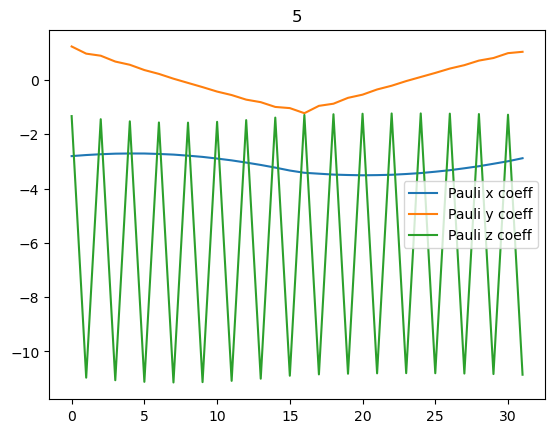

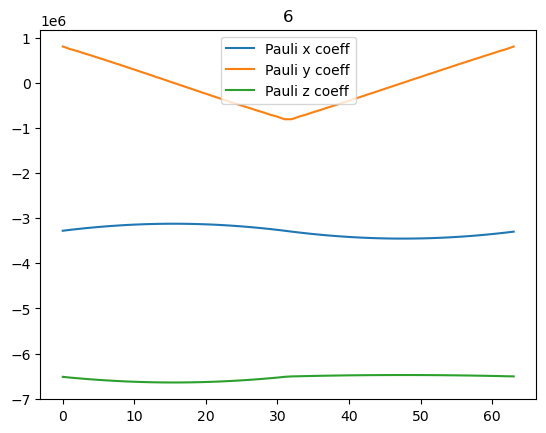

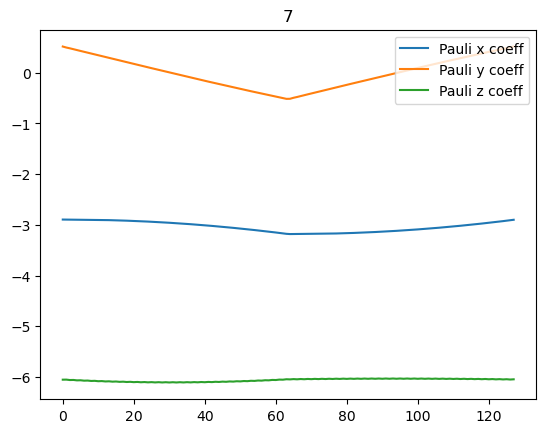

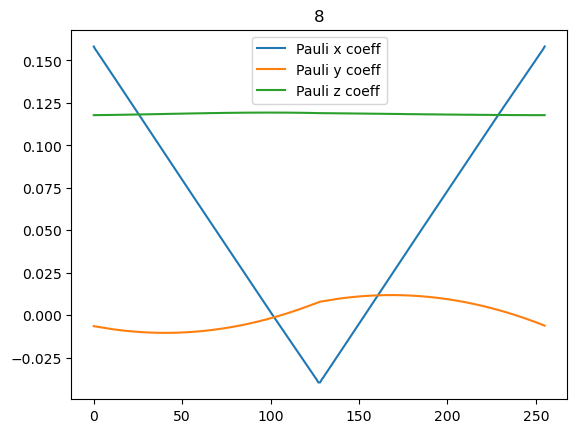

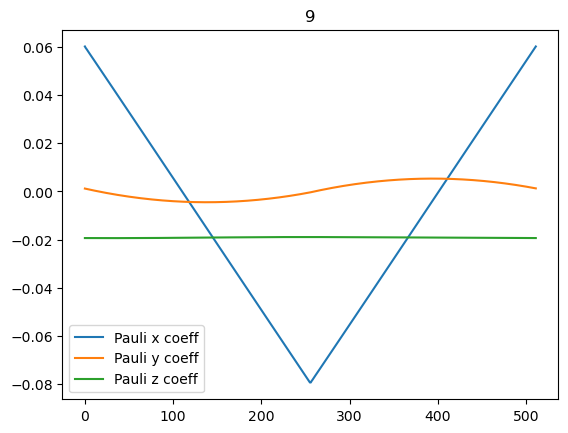

In [276]:
#lambdas=np.arange(0,10,1)

constraints=[]

nvals=np.arange(2,10,1) #11

for n in nvals:
    N=2**n
    #Generate operator set
    Ops=genOs(N)
    DOps=genDOs(N)
    
    sz=Ops[2]
    sx=Ops[0]
    Sqtsx=Ops[int(N/2)*3] #sx is multiples of 3, square wave is the N/2th mode.
    
    #Calculate for a specific lambda and plot
    AGP_approx,constraint=AGP_vary_A(0.3, Ops, DOps, sz, sx, Sqtsx, N) #0.1
    #plt.plot(np.abs(AGP_approx[1,1,:]))
    
    #plt.show()
    constraints.append(constraint)
    #Decompose into different paulis
    funcs=Paulit(AGP_approx)
    plt.plot(funcs[0,:], label="Pauli x coeff")
    plt.plot(funcs[1,:], label="Pauli y coeff")
    plt.plot(funcs[2,:], label="Pauli z coeff")
    plt.title(n)
    plt.legend()
    plt.show()

# for lam in lambdas:
#     AGP_vary_A(lam, Ops, DOps, sz, sx, Sqtsx, N)

In [277]:
fitness=[np.average(np.abs(constraint)) for constraint in constraints]
fitness

[11.666666666674942,
 49.02950358298129,
 231.6084676257945,
 1251.712961878277,
 120688.2101799415,
 10.32588502213849,
 0.09992706477429317,
 0.00043567887984051815]

In [272]:
cos

0.0024672624372201572

In [76]:
lambdas=np.arange(0,10,1)
n=4
N=2**n
#Generate operator set
Ops=genOs(N)
DOps=genDOs(N)

sz=Ops[2]
sx=Ops[0]
Sqtsx=Ops[int(N/2)*3] #sx is multiples of 3, square wave is the N/2th mode.

#Calculate for a specific lambda and plot
AGP_approx2=AGP_vary_A(1, Ops, DOps, sz, sx, Sqtsx, N)

In [194]:
DOps[3][:,:,6]

array([[-0.00000000e+00+0.j, -4.77083202e-16+4.j],
       [-4.77083202e-16+4.j, -0.00000000e+00+0.j]])

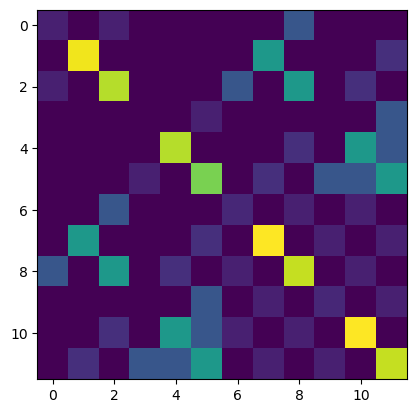

In [7]:
plt.imshow(np.abs(Mmatrix))

In [174]:
np.sum(np.einsum('ijt,jkt->ikt', Ht, Ops[12]),axis=2)

array([[24,  0],
       [ 0, 24]])

# Case 2
Can we write everything in the Walsh basis to speed up the code? Gets hard just because we have phi phi terms which are a convolution in the Walsh basis, which is not obvious at all.
As the simplest first case we study
$$H(t)= \lambda \sigma^z + (g+ A\cdot \text{Sq}(t)) \sigma^x.$$

We store this information by using three indices. The Hamiltonian is H(t) is written as H[i,j,t] where the third direction gives time. To take the trace over the physical Hilbert space part, it is just ```numpy.trace(H, axis1=0, axis2=1).``` All the operators are also written this way.

What we ultimately want to calculate is
$$
\begin{align}
M_{jk}(\lambda)&= \int \text{d}\phi\, \mathrm{Tr} \left[ g_{j,\lambda}(\phi)g_{k,\lambda}(\phi) \right] \\
b_{j}(\lambda)&= \int \text{d}\phi \mathrm{Tr} \left[ g_{j,\lambda}(\phi) \partial_{\lambda} H_{\lambda}(\phi) \right] \\
g_{j,\lambda}(\phi)&= i[H_{\lambda}(\phi), O_{j}(\phi)] +\partial_{\phi}(O_{j}(\phi))
\end{align}
$$

We store the $O_j$ as "Ops" where the first three elements are time independent $\sigma_x, \sigma_y, \sigma_z$ then the next three are $\sigma_x W_1(t), \sigma_y W_1(t), \sigma_z W_1(t)$ where the label is the natural ordering for the Walsh and so varies with $N$. Working natively in the Walsh basis, we find that we can write 
$\sum_\phi A_\phi B_\phi = \sum_l \tilde{A}_l \tilde{B}_l$ where the Walsh modes come from $A_\phi = \sum W_l(\phi) \tilde{A}_l$. This means that when expressed natively in the Walsh basis, we have
$$
\begin{align}
M_{jk}(\lambda)&= \sum_l \, \mathrm{Tr} \left[ \tilde{g}_{j,\lambda,l} \tilde{g}_{k,\lambda,l} \right] \\
b_{j}(\lambda)&= \sum_l \mathrm{Tr} \left[ \tilde{g}_{j,\lambda,l} \partial_{\lambda} \tilde{H}_{\lambda,l} \right] \\
g_{j,\lambda}(\phi)&= i[H_{\lambda}(\phi), O_{j}(\phi)] +\partial_{\phi}(O_{j}(\phi))
\end{align}
$$

# Extensive Checks

## Check on the Ops functions
Here we check that all the Ops functions are working as expected.

In [235]:
DOps=genDOs(4) #Generate the time derivative of the operators in the correct way using the discretised derivative. 
DOps[6][0,1,:] #Derivative of Walsh2 which is -Walsh3
DOps[9][0,1,:] #Derivative of Walsh3 which is Walsh2

array([ 1.+1.48959365e-16j,  1.-1.48959365e-16j, -1.-1.48959365e-16j,
       -1.+1.48959365e-16j])

In [212]:
def original(g, d):
    # If your real dlHt is (J, K, T), transpose once here to (J, I, T) before benchmarking
    # d = d.transpose(0,2,1)  # uncomment if needed
    return np.sum(np.trace(np.einsum('ijt,jkt->ikt', g, d), axis1=0, axis2=1))

def einsum_fast(g, d):
    return np.einsum('ijt,jit->', g, d, optimize=True)

def swapmul_fast(g, d):
    return (g * d.swapaxes(0, 1)).sum()

# correctness check
r1 = original(gmatrix, dlHt)
r2 = einsum_fast(gmatrix, dlHt)
r3 = swapmul_fast(gmatrix, dlHt)
print("equal? original vs einsum:", np.allclose(r1, r2))
print("equal? original vs swap  :", np.allclose(r1, r3))

# timing
n = 10000
t1 = timeit.timeit(lambda: original(gmatrix, dlHt), number=n)
t2 = timeit.timeit(lambda: einsum_fast(gmatrix, dlHt), number=n)
t3 = timeit.timeit(lambda: swapmul_fast(gmatrix, dlHt), number=n)

print(f"\nTimings over {n} runs:")
print(f"original      : {t1:.4f} s")
print(f"einsum_fast   : {t2:.4f} s")
print(f"swapmul_fast  : {t3:.4f} s")

equal? original vs einsum: True
equal? original vs swap  : True

Timings over 10000 runs:
original      : 0.0604 s
einsum_fast   : 0.0883 s
swapmul_fast  : 0.0164 s


## Sorting out the derivative

In [209]:
# def WalshD(N):
#     Walsh=sp.hadamard(N) #Generate all the Walsh functions from the Hadamard array.
#     translatedWalsh=np.roll(Walsh,1,axis=1) #Shift the whole thing over by 1 by simply pushing all the columns periodically 1.
#     Translation=1/N*np.matmul(translatedWalsh,np.transpose(Walsh)) #Invert Ax=x' to A=x' x^T to find the translation operator.
Walsh=sp.hadamard(4)
translatedWalsh=np.roll(Walsh,-1,axis=1)
Translation=1/N*np.matmul(translatedWalsh,np.transpose(Walsh))

[[ 1  1  1  1]
 [ 1 -1  1 -1]
 [ 1  1 -1 -1]
 [ 1 -1 -1  1]]
[[ 1  1  1  1]
 [-1  1 -1  1]
 [ 1 -1 -1  1]
 [-1 -1  1  1]]


In [210]:
def WalshD2(N):
    Walsh=sp.hadamard(N) #Generate all the Walsh functions from the Hadamard array.
    translatedWalsh=np.roll(Walsh,-1,axis=1) #Shift the whole thing over by 1 by simply pushing all the columns periodically 1.
    Translation=1/N*np.matmul(translatedWalsh,np.transpose(Walsh)) #Invert Ax=x' to A=x' x^T to find the translation operator.

    return N/(2*np.pi)*sp.logm(Translation) #Rewrite it as generator of translations where T=exp(2 pi G/N).

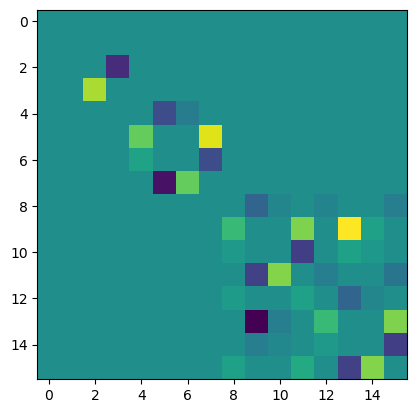

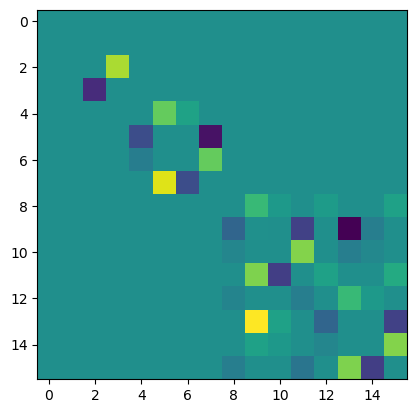

In [218]:
#Only differ by a minus sign.
plt.imshow(np.real(WalshD(16)))
plt.show()
plt.imshow(np.real(WalshD2(16)))

def Deriv(N):
    sites=np.eye(N)
    translatedsites=np.roll(sites,1,axis=1)
    Translation=1/N*np.matmul(translatedsites,np.transpose(sites)) #Invert Ax=x' to A=x' x^T to find the translation operator.

    return N/(2*np.pi)*sp.logm(Translation) #Rewrite it as generator of translations where T=exp(2 pi G/N).

In [278]:
#Testing the derivative
N=16
Ops=genOs(N)
DOps=genDOs(N)

n=15
sxW1=Ops[3*n]
Ops[6][:,:,3] #This is sx*W1(t), single root square wave. 
DsxW1=DOps[3*n]
#print(sxW1[:,:,5])
# print(sxW1[0,1,:])
# print(DsxW1[0,1,:])
DsxW12=D(sxW1,N)
print(sxW1[0,1,:])
print(np.sum(np.abs(DsxW12[0,1,:]+DsxW1[0,1,:])))

[ 0.25 -0.25 -0.25  0.25 -0.25  0.25  0.25 -0.25 -0.25  0.25  0.25 -0.25
  0.25 -0.25 -0.25  0.25]
34.34165085484819


## Checks on numerically exact AGP
Here we seek to check the code we have to find the numerically exact AGP

In [6]:
#Calculate the FAGP numerically without truncation since it is a simple two-level system

#----------------
#Find the Floquet Hamiltonian and Wlam
#----------------

def UT(Bz,g,lam, T):
    return sp.expm(-1.j*(Bz*s3+(g-lam)*s1)*T/2)@sp.expm(-1.j*(Bz*s3+(g+lam)*s1)*T/2)
    
def HFlam(Bz,g,lam, T):
    #Takes float parameters Bz, g, A=lam, omega
    #Returns 2 x 2 Floquet Hamiltonian

    return 1.j/T*sp.logm(UT(Bz,g,lam,T)) #Floquet Hamiltonian is log of Floquet unitary.

def Wlam(Bz, g, lam, T):
    #Takes float parameters Bz, g, A=lam, omega
    #Returns 2 x 2 matrix Wlam_{i,j}


    eigvals, eigvecs = np.linalg.eigh(HFlam(Bz,g,lam,T)) #Diagonalise HFlam

    return eigvecs


#---------------
# Find the micromotion operator
#---------------

def Ulam(t, Bz, g, lam, T):
    NC = t//T #Find the number of complete cycles
    tr = t%T #Find the time remaining after complete cycles.

    U_strob=np.linalg.matrix_power(UT(Bz,g,lam,T), int(NC)) 
    
    if tr < T/2:
        return sp.expm(-1.j*(Bz*s3+(g+lam)*s1)*tr)@U_strob
    else:
        return sp.expm(-1.j*(Bz*s3+(g-lam)*s1)*(tr-T/2))@sp.expm(-1.j*(Bz*s3+(g+lam)*s1)*T/2)@U_strob

def Plam(t, Bz, g, lam, T):
    return sp.expm(1.j*HFlam(Bz,g,lam,T)*t)@Ulam(t,Bz,g,lam,T) #Micromotion operator

def HFlamt0(t0 , Bz, g, lam, T):
    #Floquet Hamiltonian in the t0 gauge
    return (Plam(t0,Bz,g,lam,T).conj().T)@HFlam(Bz,g,lam,T)@Plam(t0,Bz,g,lam,T)

#---------------
# Calculate AGP
#---------------

#To do the lambda derivative, we are going to take a small difference in lambda between them.
#Define WW=W_{\lambda+deltalambda} W_lambda^dagger to save the effort of re-calculating this.
def AGPlam_num(t, Bz, g, lam, T, dl, WW):
    P2W2W1P1= Plam(t,Bz,g,lam+dl,T)@WW@(Plam(t,Bz,g,lam,T).conj().T)
    return 1.j*(P2W2W1P1-np.eye(2))/dl

def AGPlamPlot(Bz, g, lam, T):
    #Define the desired parameters
    dl=0.01 #Step-size for the derivative
    WW=Wlam(Bz, g, lam+dl, T)@(Wlam(Bz, g, lam, T).conj().T) #Find the W product

    #Define the t range for plotting
    Nt=100
    tvals=np.linspace(0,T,Nt)
    funcs=np.empty((3,Nt), dtype="complex")#Storing the time-dependence of the different parts
    for i,t in enumerate(tvals):
        AGP_num=AGPlam_num(t,Bz,g,lam, T,dl,WW)
        funcs[0,i], funcs[1,i], funcs[2,i]=PauliDecompose(AGP_num)
    
    plt.plot(funcs[0,:], label="Pauli x coeff")
    plt.plot(funcs[1,:], label="Pauli y coeff")
    plt.plot(funcs[2,:], label="Pauli z coeff")
    plt.legend()
    plt.show()

#AGPlamPlot(1,0.5,0.3, 2*np.pi/100)

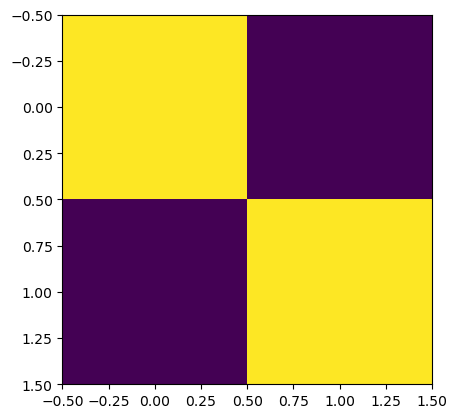

In [ ]:
#Confirming that Wlam does diagonalise HFlam
plt.imshow(np.abs(Wlam(1,0.5,0.3, 2*np.pi).conj().T@HFlam(1,0.5,0.3, 2*np.pi)@Wlam(1,0.5,0.3, 2*np.pi)))

#Checking the Floqet Hamiltonian
HFlamt0(0,1,0.5,0.3,2*np.pi)-HFlam(1,0.5,0.3, 2*np.pi) #Are they identical?
#Are the eigenvalues the same for different t0? Yes they are.
eigvals0, eigvecs0 = np.linalg.eigh(HFlamt0(0,1,0.5,0.3,2*np.pi))
eigvals1, eigvecs1 = np.linalg.eigh(HFlamt0(0.9,1,0.5,0.3,2*np.pi))
eigvals0-eigvals1  #Difference is 0.

def Gtilde(t, Bz, g, lam, T, dl, WW):
    dl=10**(-10)
    return 1.j*commutator(HFlamt0(t,Bz,g,lam,T), AGPlam_num(t,Bz,g,lam,T,dl,WW)) - (HFlamt0(t,Bz,g,lam+dl,T)-HFlamt0(t,Bz,g,lam,T))/dl

def numAGPtest_S9(Bz, g, lam, T, Nt):
    dl=0.01 #Step-size for the derivative
    WW=Wlam(Bz, g, lam+dl, T)@(Wlam(Bz, g, lam, T).conj().T) #Find the W product

    tvals=np.linspace(0,T,Nt)
    G_list=[]
    R_list=[]
    for t in tvals:
        Gtilde_t=Gtilde(t,Bz,g,lam,T,dl,WW)
        AGP_num=AGPlam_num(t,Bz,g,lam,T,dl,WW)
        H_Floq=HFlamt0(t,Bz,g,lam,T)
        dHlam=(HFlamt0(t,Bz,g,lam+dl,T)-HFlamt0(t,Bz,g,lam,T))/dl

        G_list.append(Gtilde_t)
        R_t=1.j*commutator(H_Floq, AGP_num) + 1.j*commutator(dHlam, AGP_num) + (dHlam)
        R_list.append(R_t)

    # Convert lists to arrays for easier manipulation
    G_list = np.array(G_list)
    R_list = np.array(R_list)